# https://www.kaggle.com/c/mercari-price-suggestion-challenge 
# https://www.kaggle.com/c/home-credit-default-risk

Выбрать одно из двух соревнований. Выбирайте по данным, с которыми вам интереснее работать.

Работать буду с https://www.kaggle.com/c/mercari-price-suggestion-challenge

In [10]:
import time
import re
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_union, make_pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder, MinMaxScaler,  Imputer, LabelBinarizer, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV

# Ансамбли

import xgboost as xgb
import lightgbm as lgb

%matplotlib inline
plt.rcParams["figure.figsize"] = (30, 16)
pd.options.display.float_format = '{:.2f}'.format

In [11]:
df = pd.read_csv('train.tsv', sep='\t')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


### Используйте параметр nrows, чтобы уменьшить выборку и сделать базовый разведочный анализ данных

In [13]:
df = pd.read_csv('train.tsv', nrows=100_000, sep='\t')

In [14]:
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.00,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.00,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.00,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.00,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.00,0,Complete with certificate of authenticity


# Задание
1. Сделать baseline submission
  * Исследовать признак price. 
  * Исследовать признак price в зависимости от brand_name или других признаков
2. Реализовать цикл анализа
  * признаки -> модель -> настройка параметров -> лучшая модель и ее значение метрики качества на кросс-валидации
3. Провести простые преобразования признаков и добавление простых признаков
  * разделить category_name на уровни
  * посмотреть на наличие числовых значений в описании и имени
4. Составить план по применению нескольких моделей на разных признаках
  * спроектируйте эксперимент. Нужно заранее спланировать порядок перебора признаков и моделей. Потом только писать код. Обратный порядок вызывает необходимость переписывать существующий код, это трата времени
5. Просмотреть 1-5 kernel на kaggle. (только в таком порядке. сначала работаем самостоятельно, потом смотрим идеи других. при появлении опыта можно сразу начинать с них)
6. Построить модель, выбрать лучшую
7. Построить ансамбль, настрить парамертры. Сравнить с другими моделями.
8. Оценить качество на CV.

# Анализ признака price

In [15]:
df['price'].describe()

count   100000.00
mean        26.70
std         37.94
min          0.00
25%         10.00
50%         17.00
75%         29.00
max       1506.00
Name: price, dtype: float64

In [16]:
price = df['price']

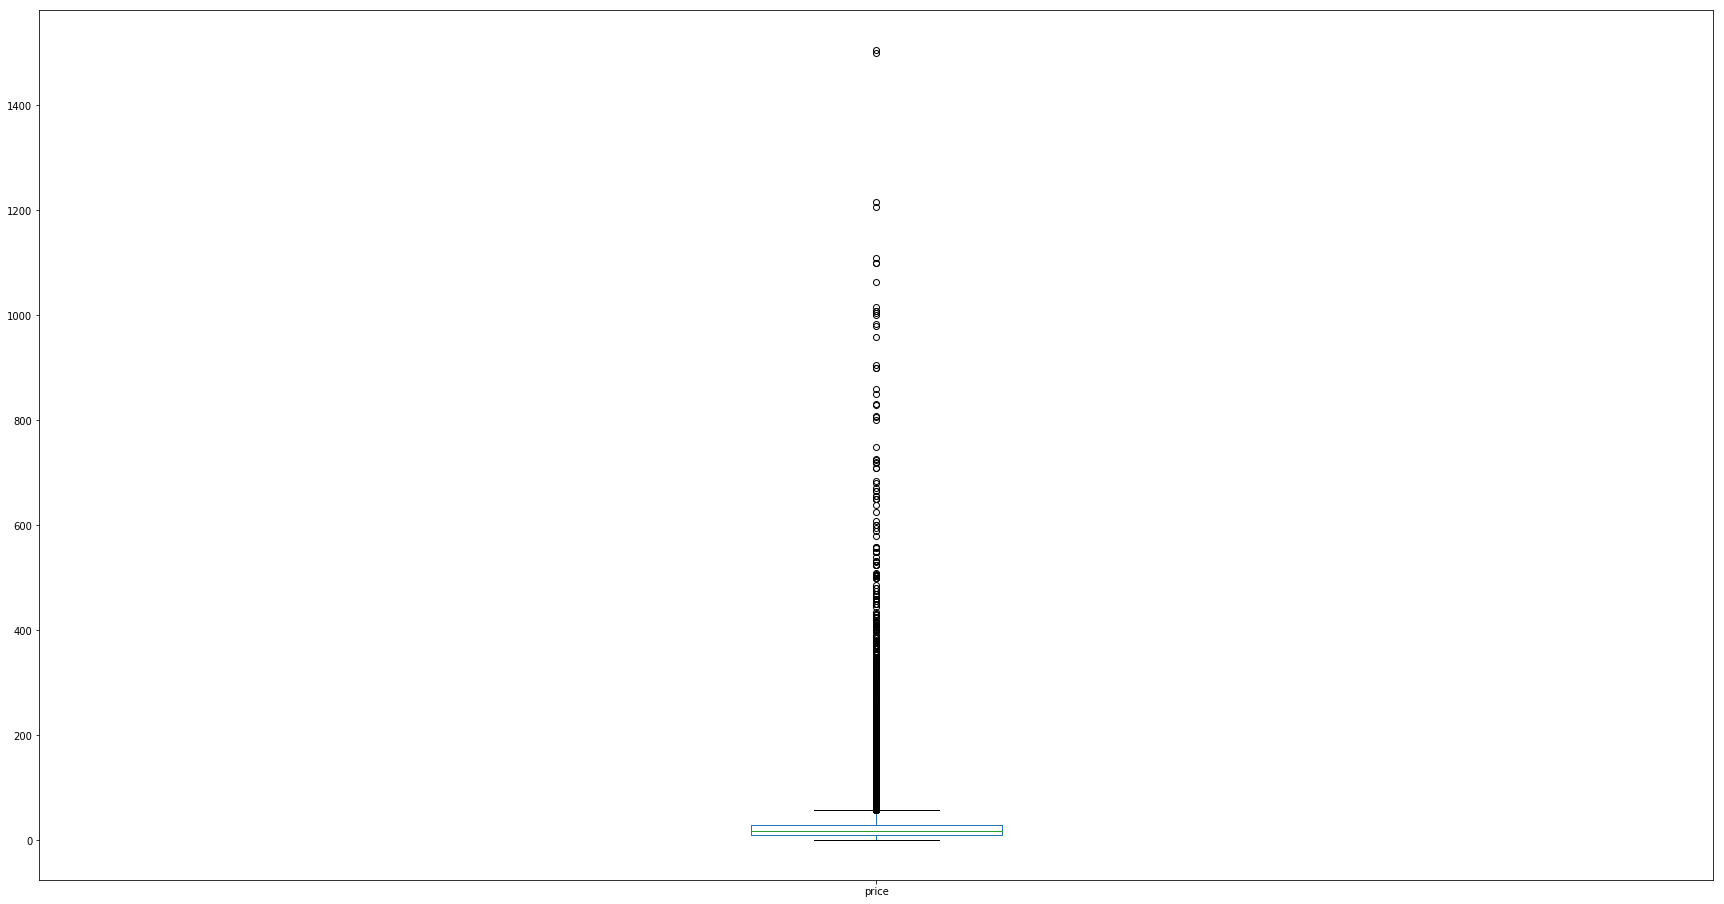

In [17]:
price.plot(kind = 'box')

Много выбросов в большую сторону

Займемся признаками

train_id or test_id - the id of the listing - id покупки, нам ничего не скажет

name - название

category_name - категория товаров

brand_name - имя бренда

item_condition_id - состояние, указанное продавцом

price - цена

shipping - 1, если стоимость доставки оплачивается продавцом, а 0 - покупателем. (возможно будет влиять на дешевые товары)

item_description - полное описание товара


Из более менее четких признаков мы имеем 1 категориальный признак - brand_name, посмотрим зависимость от этой переменной. Остальные переменные скрытые и их нужно преобразовывать как-то

In [18]:
brand = df['brand_name']

In [19]:
brand.isnull().sum()

42924

43_000  - нулевые из 1_000_000 - т.е. довольно много

Посмотрим количество уникальных значений и сколько раз они повторяются

In [20]:
brand.unique().shape

(2068,)

In [21]:
count_brand = df.groupby('brand_name')['train_id'].nunique()


In [22]:
most_popular_brand = count_brand.sort_values(ascending=False)[:10]
most_popular_brand

brand_name
PINK                 3707
Nike                 3623
Victoria's Secret    3227
LuLaRoe              2115
Apple                1149
FOREVER 21           1044
Nintendo             1030
Lululemon             980
Michael Kors          907
American Eagle        893
Name: train_id, dtype: int64

In [23]:
(count_brand<2).sum()

806

Довольно много брэндов, для которых выборка очень мала

In [24]:
most_popular_brand = most_popular_brand.reset_index()['brand_name']
most_popular_brand

0                 PINK
1                 Nike
2    Victoria's Secret
3              LuLaRoe
4                Apple
5           FOREVER 21
6             Nintendo
7            Lululemon
8         Michael Kors
9       American Eagle
Name: brand_name, dtype: object

Построим по первым самым популярным брэндам распределение цен

In [25]:
df_popular = df[df['brand_name'].isin(most_popular_brand)]

In [26]:
df_popular.head(2)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
8,8,Girls Nike Pro shorts,3,Sports & Outdoors/Apparel/Girls,Nike,19.00,0,Girls Size small Plus green. Three shorts total.
11,11,New vs pi k body mists,1,Beauty/Fragrance/Women,Victoria's Secret,34.00,0,(5) new vs pink body mists (2.5 oz each) Fresh...


In [27]:
gb = df_popular.groupby('brand_name')

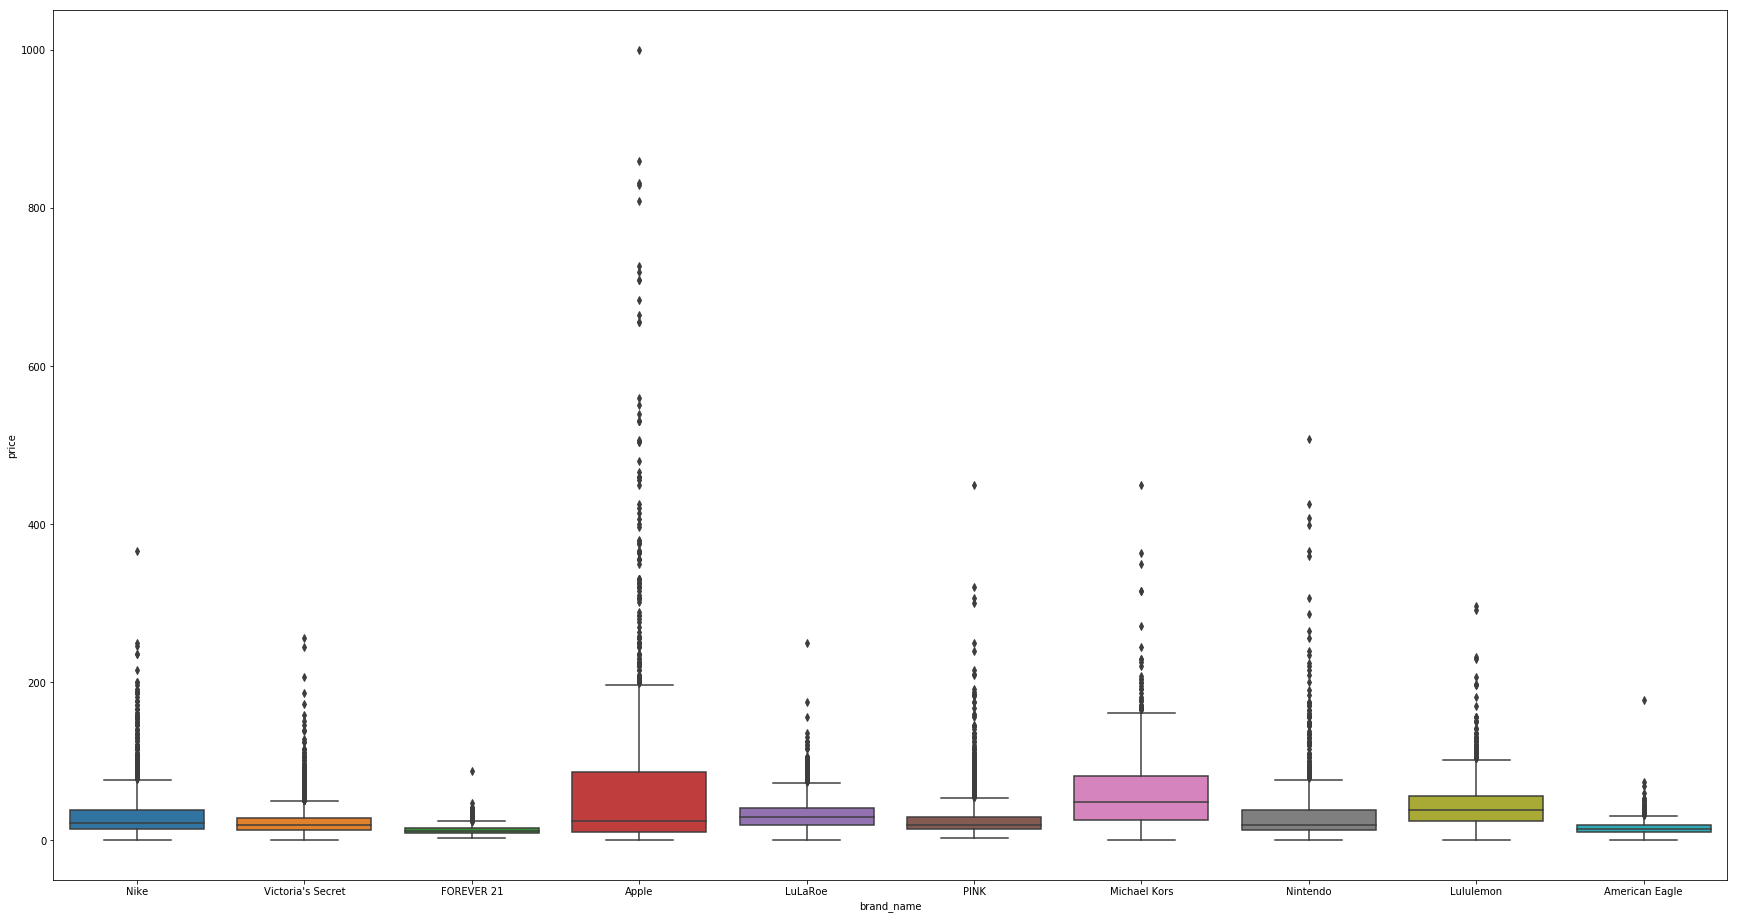

In [28]:
sns.boxplot(x="brand_name", y="price", data=df_popular)

Корреляция есть, но очень незначительная и довольно много выбросов

Сделаем анализ category_name - узнаем сколько / в имени

In [29]:
df['category_name'].str.count('/').describe()

count   99583.00
mean        2.01
std         0.10
min         2.00
25%         2.00
50%         2.00
75%         2.00
max         4.00
Name: category_name, dtype: float64

In [30]:
df.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.00,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.00,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.00,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.00,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.00,0,Complete with certificate of authenticity


Может есть неуникальные имена:

In [31]:
df['name'].isnull().sum()

0

In [32]:
df.groupby('name')['train_id'].nunique().sort_values(ascending=False)[:20]

name
Bundle                  145
Converse                 29
Nike                     29
Dress                    27
Reserved                 25
Miss Me Jeans            25
Lularoe OS leggings      24
BUNDLE                   23
Coach purse              23
American Eagle Jeans     22
Romper                   21
Bundle!                  21
Lularoe TC leggings      21
Sunglasses               20
Coach wallet             20
Lularoe Randy            20
Boots                    19
Hollister jeans          19
Shorts                   18
Cardigan                 18
Name: train_id, dtype: int64

# Составим предварительный план анализа

- Подготовим признаки:
    - brand_name - все нулевые и те, что встрачается 2 раза - относим в отдельную категорию
    - Категории - делим на признаки
- Строим модель с xgboost и randomforest,
    - выполняем поиск по сетке с cv = 5
    - оцениваем результат на mselog
- Пытаемся ввести новые признаки:
    - например мешок слов
- перестраиваем модель снова
- смотрим на kaggle пару идей и пробуем их
- строим окончательную модель

In [33]:
df_work = df.copy()

In [34]:
y = df_work['price']

In [35]:
df_work = df_work.drop('price', axis=1)

In [36]:
df_work['brand_name'] = df_work['brand_name'].fillna(value = 'NONE')

In [37]:
df_work_brand_name = df_work.groupby('brand_name')['train_id'].nunique()

In [39]:
df_work.loc[df_work['brand_name'].isin(df_work_brand_name[df_work_brand_name<3]), 'brand_name'] = 'NONE'

In [40]:
df_work.drop('train_id', axis=1, inplace=True)

In [41]:
df_work.head(2)

,name,item_condition_id,category_name,brand_name,shipping,item_description
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NONE,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,0,This keyboard is in great condition and works ...


In [42]:
df_work[['category_1', 'category_2', 'category_3', 'category_4', 'category_5']] = df_work['category_name'].str.split('/', expand = True)

In [43]:
df_work[['category_1', 'category_2', 'category_3', 'category_4', 'category_5']] = df_work[['category_1', 'category_2', 'category_3', 'category_4', 'category_5']].fillna('NONE')

In [44]:
df_work.head(2)

,name,item_condition_id,category_name,brand_name,shipping,item_description,category_1,category_2,category_3,category_4,category_5
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NONE,1,No description yet,Men,Tops,T-shirts,NONE,NONE
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,NONE,NONE


Сначала сделаем на RandomForest, как более простом

In [45]:
from sklearn.ensemble import RandomForestRegressor

In [46]:
clf1 = RandomForestRegressor()

In [47]:
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [48]:
categorial_columns = ['brand_name', 'category_1', 'category_2', 'category_3', 'category_4', 'category_5']

In [49]:
numerical_columns = ['item_condition_id', 'shipping']

In [50]:
bag_column = ['name']

In [51]:
 column_trans = ColumnTransformer(
 [('category', OneHotEncoder(handle_unknown = 'ignore'), categorial_columns)],
 remainder='drop')

In [52]:
steps = [('column_trans', column_trans), ('regr', RandomForestRegressor())]
pipeline = Pipeline(steps)

In [53]:
solve_columns =  categorial_columns + numerical_columns
solve_columns

['brand_name',
 'category_1',
 'category_2',
 'category_3',
 'category_4',
 'category_5',
 'item_condition_id',
 'shipping']

In [54]:
solve_columns2 = solve_columns + bag_column
solve_columns2

['brand_name',
 'category_1',
 'category_2',
 'category_3',
 'category_4',
 'category_5',
 'item_condition_id',
 'shipping',
 'name']

In [55]:
df_work[solve_columns].isnull().sum(axis=0)

brand_name           0
category_1           0
category_2           0
category_3           0
category_4           0
category_5           0
item_condition_id    0
shipping             0
dtype: int64

In [56]:
res =  cross_val_score(pipeline, df_work[solve_columns], y, scoring='neg_mean_squared_log_error', cv=5, n_jobs=-1)

In [57]:
res

array([-0.41074672, -0.41589603, -0.40627871, -0.40793178, -0.41501749])

In [58]:
np.power(np.mean(res)*(-1), 0.5)

0.6412286213833666

При этом лучшее решение - 0.38 - очень далеко

Теперь обучим XGBoost

In [64]:
import xgboost as xgb
clf = xgb.XGBRegressor()
steps = [('column_trans', column_trans), ('XGB', clf)]
pipeline = Pipeline(steps)


In [65]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'column_trans', 'XGB', 'column_trans__n_jobs', 'column_trans__remainder', 'column_trans__sparse_threshold', 'column_trans__transformer_weights', 'column_trans__transformers', 'column_trans__category', 'column_trans__category__categorical_features', 'column_trans__category__categories', 'column_trans__category__dtype', 'column_trans__category__handle_unknown', 'column_trans__category__n_values', 'column_trans__category__sparse', 'XGB__base_score', 'XGB__booster', 'XGB__colsample_bylevel', 'XGB__colsample_bytree', 'XGB__gamma', 'XGB__learning_rate', 'XGB__max_delta_step', 'XGB__max_depth', 'XGB__min_child_weight', 'XGB__missing', 'XGB__n_estimators', 'XGB__n_jobs', 'XGB__nthread', 'XGB__objective', 'XGB__random_state', 'XGB__reg_alpha', 'XGB__reg_lambda', 'XGB__scale_pos_weight', 'XGB__seed', 'XGB__silent', 'XGB__subsample'])

In [66]:
xgb_hyperparams = {'XGB__n_estimators': [1000, 2000, 3000],
                   'XGB__learning_rate': [0.01, 0.03, 0.05, 0.07],
                   'XGB__max_depth': [3, 4, 5]}

grid_search = RandomizedSearchCV(pipeline,
                          xgb_hyperparams,
                          #fit_params=fit_parameters,
                          scoring='neg_mean_squared_error',
                          cv=5,
                          n_jobs=-1,
                          n_iter=5,
                          verbose=3)

grid_search.fit(X_train[solve_columns], y_train)


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  25 | elapsed:   46.5s remaining:   59.2s
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:  1.1min remaining:   15.7s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.1min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('column_trans', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('category', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_valu...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'XGB__n_estimators': [1000, 2000, 3000], 'XGB__learning_rate': [0.01, 0.03, 0.05, 0.07], 'XGB__max_depth': [3, 4, 5]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=3)

In [67]:
grid_search.best_params_

{'XGB__n_estimators': 2000, 'XGB__max_depth': 5, 'XGB__learning_rate': 0.05}

In [68]:
grid_search.best_score_

-1099.4443254092835

In [69]:
y_predict = grid_search.predict(X_test[solve_columns])

In [70]:
y_predict[y_predict<0]=0

In [71]:
from  sklearn.metrics import mean_squared_log_error

In [72]:
mean_squared_log_error(y_predict, y_test)

0.42636184326931414

Ошибка близка к лесу.

Добавим еще мешок слов по имени

In [73]:
from  sklearn.feature_extraction.text import CountVectorizer

In [74]:
 column_trans = ColumnTransformer(
 [('category', OneHotEncoder(handle_unknown = 'ignore'), categorial_columns), ('bag', CountVectorizer(max_df = 1000, min_df = 2, max_features= 100, stop_words = 'english' ), bag_column[0])],
 remainder='drop')

In [76]:
X_train, X_test, y_train, y_test = train_test_split(df_work[solve_columns2], y, test_size=0.2, random_state=42)

In [77]:
clf = xgb.XGBRegressor()
steps = [('column_trans', column_trans), ('XGB', clf)]
pipeline = Pipeline(steps)
xgb_hyperparams = {'XGB__n_estimators': [2000, 3000],
                   'XGB__learning_rate': [0.01, 0.03, 0.05, 0.07],
                   'XGB__max_depth': [5, 10]}

grid_search = RandomizedSearchCV(pipeline,
                          xgb_hyperparams,
                          #fit_params=fit_parameters,
                          scoring='neg_mean_squared_error',
                          cv=5,
                          n_jobs=-1,
                          n_iter=5,
                          verbose=3)

grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  25 | elapsed:  2.1min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:  4.0min remaining:   59.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  4.3min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('column_trans', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('category', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_valu...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'XGB__n_estimators': [2000, 3000], 'XGB__learning_rate': [0.01, 0.03, 0.05, 0.07], 'XGB__max_depth': [5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=3)

In [78]:
grid_search.best_params_

{'XGB__n_estimators': 2000, 'XGB__max_depth': 5, 'XGB__learning_rate': 0.07}

In [79]:
grid_search.best_score_

-1051.1031724192162

In [80]:
y_predict = grid_search.predict(X_test[solve_columns2])

In [81]:
y_predict[y_predict<0]=0

In [82]:
mean_squared_log_error(y_predict, y_test)

0.41362788118518057

совсем не помогло

# Идеи с Kaggle

Посмотрев на kaggle - перейти от y к log(y), добавить параметр как длина description, попробовать на большей выборке (по лучшим параметрам на данный момент)

Рассмотрим np.log(y),  так как много выбросов и требуемая характеристика mean_squared_log_error

In [83]:
y[y<=0.1]=0.1

In [84]:
X_train, X_test, y_train, y_test = train_test_split(df_work[solve_columns2], np.log(y), test_size=0.2, random_state=42)


In [85]:
np.any(np.isnan(y_train))

False

In [86]:
np.all(np.isfinite(y_train))

True

In [87]:
clf = xgb.XGBRegressor(missing = 0, reg_alpha=0.01)
column_trans = ColumnTransformer(
 [('category', OneHotEncoder(handle_unknown = 'ignore'), categorial_columns), 
  ('bag', CountVectorizer(max_df = 1000, min_df = 5, max_features= 1000, stop_words = 'english' ), bag_column[0])],
 remainder='drop')
steps = [('column_trans', column_trans), ('XGB', clf)]
pipeline = Pipeline(steps)
xgb_hyperparams = {'XGB__n_estimators': [2000, 2500],
                   'XGB__learning_rate': [0.01, 0.03, 0.05, 0.07],
                   'XGB__max_depth': [5, 10]}

grid_search = RandomizedSearchCV(pipeline,
                          xgb_hyperparams,
                          scoring='neg_mean_squared_error',
                          cv=4,
                          n_jobs=-1,
                          n_iter=6,
                          verbose=3)

grid_search.fit(X_train, y_train)


Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  24 | elapsed:  2.9min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:  5.2min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  5.3min finished


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('column_trans', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('category', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_valu...     reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
          fit_params=None, iid='warn', n_iter=6, n_jobs=-1,
          param_distributions={'XGB__n_estimators': [2000, 2500], 'XGB__learning_rate': [0.01, 0.03, 0.05, 0.07], 'XGB__max_depth': [5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=3)

In [88]:
grid_search.best_params_

{'XGB__n_estimators': 2000, 'XGB__max_depth': 10, 'XGB__learning_rate': 0.07}

In [89]:
grid_search.best_score_

-0.3709797340034744

In [90]:
y_predict = grid_search.predict(X_test)

In [93]:
y_predict[y_predict<0]=0

In [94]:
from sklearn.metrics import mean_squared_error

In [95]:
mean_squared_error(y_predict, y_test)

0.3757949429274036

Помогло не очень. Теперь добавим как признак длину description (так как есть неплохая зависимость длины описания от цены)

In [96]:
df_work['lenght_description'] = df_work['item_description'].str.len()

In [97]:
solve_columns3 = solve_columns2 + ['lenght_description']

In [98]:
X_train, X_test, y_train, y_test = train_test_split(df_work[solve_columns3], np.log(y), test_size=0.2, random_state=42)
clf = xgb.XGBRegressor(missing = 0, reg_alpha=0.01)
column_trans = ColumnTransformer(
 [('category', OneHotEncoder(handle_unknown = 'ignore'), categorial_columns), 
  ('bag', CountVectorizer(max_df = 1000, min_df = 5, max_features= 1000, stop_words = 'english' ), bag_column[0])],
 remainder='drop')
steps = [('column_trans', column_trans), ('XGB', clf)]
pipeline = Pipeline(steps)
xgb_hyperparams = {'XGB__n_estimators': [1000, 2000, 3000],
                   'XGB__learning_rate': [0.01, 0.03, 0.05, 0.07],
                   'XGB__max_depth': [5, 10]}

grid_search = RandomizedSearchCV(pipeline,
                          xgb_hyperparams,
                          scoring='neg_mean_squared_error',
                          cv=4,
                          n_jobs=-1,
                          n_iter=6,
                          verbose=3)

grid_search.fit(X_train, y_train)


Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  24 | elapsed:  1.8min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:  4.3min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  4.9min finished


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('column_trans', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('category', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_valu...     reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
          fit_params=None, iid='warn', n_iter=6, n_jobs=-1,
          param_distributions={'XGB__n_estimators': [1000, 2000, 3000], 'XGB__learning_rate': [0.01, 0.03, 0.05, 0.07], 'XGB__max_depth': [5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=3)

In [99]:
y_predict = grid_search.predict(X_test)

In [100]:
y_predict[y_predict<0]=0

In [102]:
mean_squared_error(y_predict, y_test)

0.37571787001572676

In [104]:
grid_search.best_params_

{'XGB__n_estimators': 3000, 'XGB__max_depth': 10, 'XGB__learning_rate': 0.05}

In [109]:
regr = grid_search.best_estimator_.named_steps['XGB']

In [119]:
regr.feature_importances_

array([0.        , 0.00020574, 0.        , ..., 0.00034475, 0.0002391 ,
       0.00097308], dtype=float32)

In [122]:
X_train.head(2)

,brand_name,category_1,category_2,category_3,category_4,category_5,item_condition_id,shipping,name,lenght_description
75220,NONE,Women,Underwear,Panties,NONE,NONE,1,1,Hanes Constant Comfort X-Temp Underwear,264
48955,Wet Seal,Women,Skirts,"Straight, Pencil",NONE,NONE,3,1,Pencil skirt,18


In [123]:
column_trans.fit_transform(X_train)[:1].todense().shape

(1, 3714)

Последняя попытка - обучение на всей выборке, в связи с размером - только XGBoost c параметрами: {'XGB__n_estimators': 2000, 'XGB__max_depth': 10 'XGB__learning_rate': 0.05}


In [124]:
df = pd.read_csv('train.tsv', sep='\t')
df_work = df.copy()
y = df_work['price']
df_work = df_work.drop('price', axis=1)
df_work['brand_name'] = df_work['brand_name'].fillna(value = 'NONE')
df_work_brand_name = df_work.groupby('brand_name')['train_id'].nunique()
df_work.loc[df_work['brand_name'].isin(df_work_brand_name[df_work_brand_name<3]), 'brand_name'] = 'NONE'
df_work.drop('train_id', axis=1, inplace=True)
df_work[['category_1', 'category_2', 'category_3', 'category_4', 'category_5']] = df_work['category_name'].str.split('/', expand = True)
df_work[['category_1', 'category_2', 'category_3', 'category_4', 'category_5']] = df_work[['category_1', 'category_2', 'category_3', 'category_4', 'category_5']].fillna('NONE')


In [125]:
categorial_columns = ['brand_name', 'category_1', 'category_2', 'category_3', 'category_4', 'category_5']

In [126]:
numerical_columns = ['item_condition_id', 'shipping']

In [127]:
bag_column = ['name']

In [128]:
solve_columns =  categorial_columns + numerical_columns
solve_columns2 = solve_columns + bag_column
solve_columns3 = solve_columns2 + ['lenght_description']

In [129]:
df_work['lenght_description'] = df_work['item_description'].str.len()

In [130]:
y[y<=0.1]=0.1

In [131]:
X_train, X_test, y_train, y_test = train_test_split(df_work[solve_columns3], np.log(y), test_size=0.2, random_state=42)


In [132]:
clf = xgb.XGBRegressor(missing = 0, reg_alpha=0.01, n_estimators=2000, max_depth=10, learning_rate=0.05, n_jobs=-1)
column_trans = ColumnTransformer(
 [('category', OneHotEncoder(handle_unknown = 'ignore'), categorial_columns), 
  ('bag', CountVectorizer(max_df = 1000, min_df = 5, max_features= 1000, stop_words = 'english' ), bag_column[0])],
 remainder='drop')
steps = [('column_trans', column_trans), ('XGB', clf)]
pipeline = Pipeline(steps)


In [133]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('column_trans', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('category', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_valu...     reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [146]:
y_predict = pipeline.predict(X_test)
mean_squared_error(y_predict, y_test)

0.37595732321814923

In [147]:
0.37595732321814923**0.5

0.6131535886041516

In [148]:
clf = xgb.XGBRegressor(booster ='gblinear',  missing = 0, reg_alpha=0.01, n_estimators=2000, max_depth=10, learning_rate=0.05, nthread=-1)
column_trans = ColumnTransformer(
 [('category', OneHotEncoder(handle_unknown = 'ignore'), categorial_columns), 
  ('bag', CountVectorizer(max_df = 1000, min_df = 5, max_features= 1000, stop_words = 'english' ), bag_column[0])],
 remainder='drop')
steps = [('column_trans', column_trans), ('XGB', clf)]
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)
y_predict = pipeline.predict(X_test)

In [149]:
mean_squared_error(y_predict, y_test)

0.627000480672827

In [156]:
solve_columns4 = solve_columns3 + ['item_description']

In [163]:
df_work['item_description'] = df['item_description']

In [164]:
df_work['item_description'] = df_work['item_description'].fillna("NONE")

In [165]:
X_train, X_test, y_train, y_test = train_test_split(df_work[solve_columns4], np.log(y), test_size=0.2, random_state=42)


In [166]:
clf = xgb.XGBRegressor(missing = 0, reg_alpha=0.01, n_estimators=2000, max_depth=15, learning_rate=0.05, nthread=-1)
column_trans = ColumnTransformer(
 [('category', OneHotEncoder(handle_unknown = 'ignore'), categorial_columns), 
  ('bag', CountVectorizer(max_df = 1000, min_df = 5, max_features= 1000, stop_words = 'english' ), bag_column[0]), 
 ('bag_desc', CountVectorizer(max_df = 1000, min_df = 5, max_features= 1000, stop_words = 'english' ), 'item_description')],
 remainder='drop')
steps = [('column_trans', column_trans), ('XGB', clf)]
pipeline = Pipeline(steps)


In [167]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('column_trans', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('category', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_valu...     reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [168]:
y_predict = pipeline.predict(X_test)
mean_squared_error(y_predict, y_test)

0.35522858225541376

In [171]:
0.355**0.5

0.5958187643906492

Максимально лучший полученный результат - 0,6. Не очень хороший, но основная информация в описании, текстовая информация изучается в 3 модуле. Результат улучшился (с 0,41 до 0,355). Но очень недостаточно